# 프로젝트: ControlNet으로 조건을 준 이미지 생성하기

# 목차
- 윤곽선 검출
- 인체 자세 감지
- 윤곽선 검출 + 인체 자세 감지

In [1]:
# Stable Diffusion 설치
!pip install qq diffusers==0.31

## 윤곽선 검출


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.88.0.1'

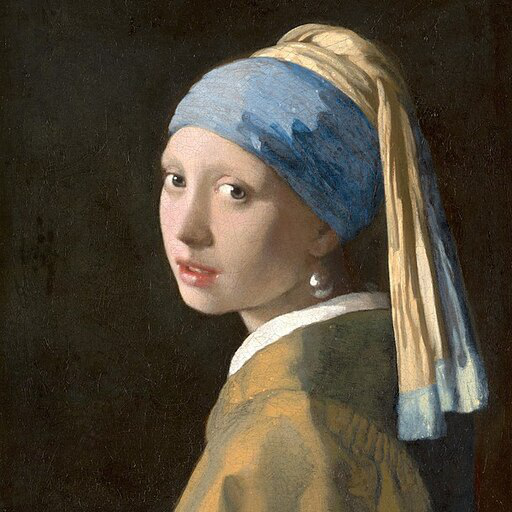

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

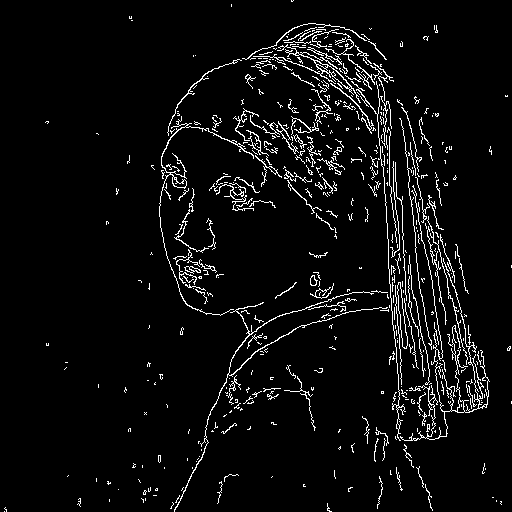

In [3]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [4]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인 불러오기
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

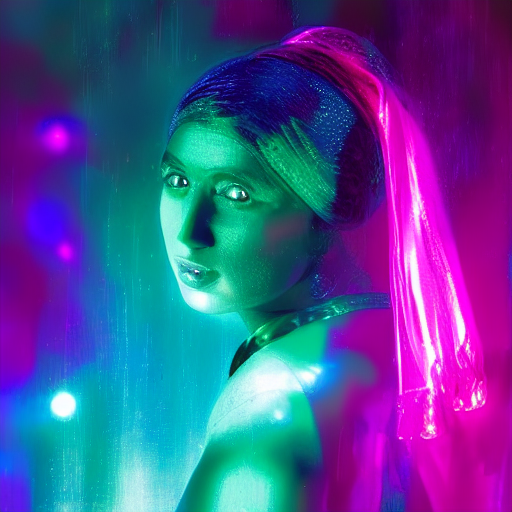

In [5]:
from diffusers import UniPCMultistepScheduler

canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/diffusers/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/50 [00:00<?, ?it/s]

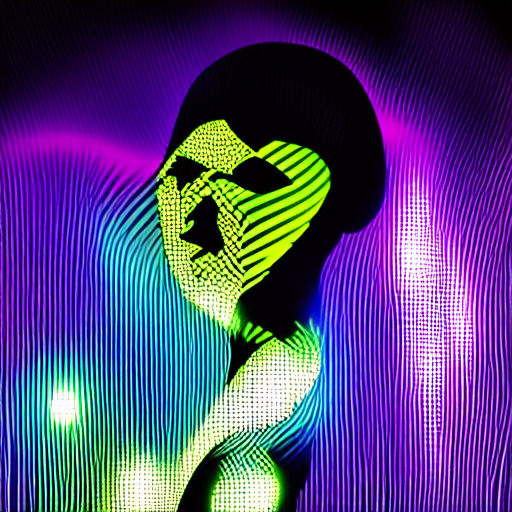

In [6]:
# 스케줄러 초기화
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 프롬프트 정의
positive_prompt = "A disco dancer with colorful lights"
negative_prompt = "blurry, low-quality"

# 이미지 생성
canny_image2 = canny_pipe(
    prompt=positive_prompt, 
    negative_prompt=negative_prompt, 
    num_inference_steps=50,  # 고해상도
    guidance_scale=7.5,  # 프롬프트 영향
    controlnet_conditioning_scale=1.0,  # ControlNet 영향
    generator=generator,  # 시드를 고정하여 동일한 이미지 생성
    image=canny_image  # Canny 윤곽선 이미지를 입력
).images[0]

# 이미지 저장 및 출력
canny_image2.save("/aiffel/aiffel/diffusers/canny_image2.png")
canny_image2.show()

In [7]:
# 메모리 삭제
torch.cuda.empty_cache()

## 인체 자세 감지

In [8]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

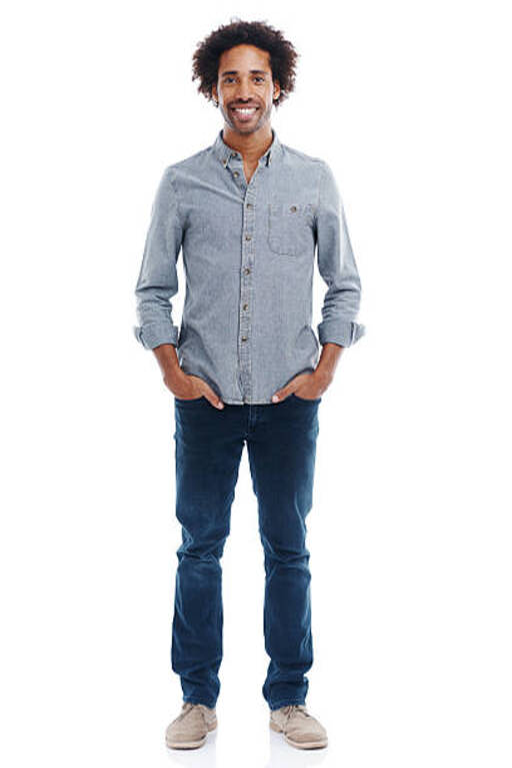

In [9]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# 이미지 리사이징
def resize_image(image, new_width, new_height):
    return image.resize((new_width, new_height), Image.LANCZOS)

openpose_image = resize_image(openpose_image, 512, 768)

openpose_image

cuda


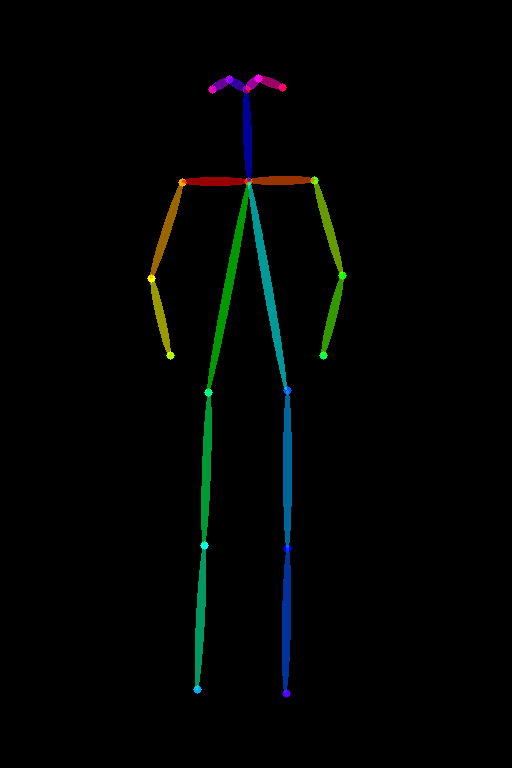

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

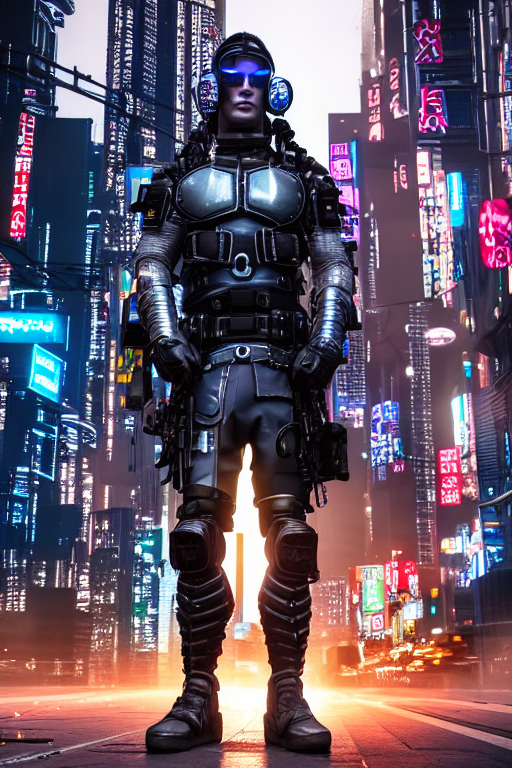

In [12]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(42)

#프롬프트를 작성합니다. 
prompt = "A futuristic cyberpunk warrior standing in the city"
negative_prompt = "low-quality, distorted, bad anatomy"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # Higher steps for more detail
    generator=generator,
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/50 [00:00<?, ?it/s]

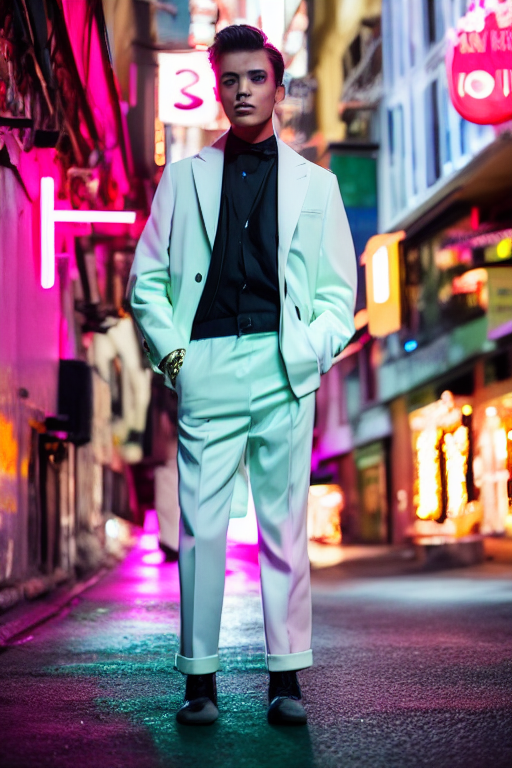

In [13]:
# seed 지정
generator = torch.manual_seed(43)

# prompts 정의
prompt = "A fashionable model in a neon-lit city"
negative_prompt = "low-resolution, blurry, distorted, bad anatomy, extra limbs, artifacts"

# 이미지 생성
openpose_image2 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # Higher steps for more detail
    guidance_scale=9.0,  # Controls adherence to prompt
    controlnet_conditioning_scale=1.2,  # Adjusts influence of OpenPose conditioning
    generator=generator,
    image=openpose_image
).images[0]

# 이미지 저장 및 출력
openpose_image2.save("/aiffel/aiffel/diffusers/openpose_image2.png")
openpose_image2.show()

  0%|          | 0/50 [00:00<?, ?it/s]

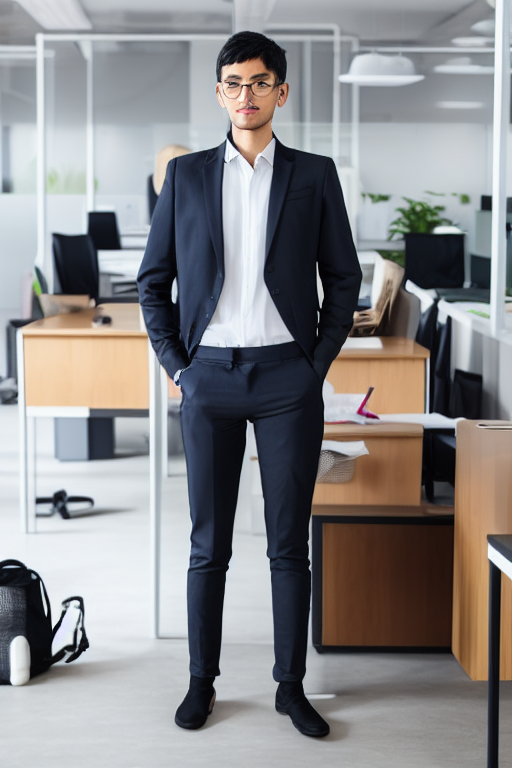

In [14]:
# seed 지정
generator = torch.manual_seed(44)

# prompts 정의
prompt = "An ordinary office worker standing in the office"
negative_prompt = "low-resolution, blurry, artifacts"

# 이미지 생성
openpose_image3 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # Higher steps for more detail
    guidance_scale=9.0,  # Controls adherence to prompt
    controlnet_conditioning_scale=1.2,  # Adjusts influence of OpenPose conditioning
    generator=generator,
    image=openpose_image
).images[0]

# 이미지 저장 및 출력
openpose_image3.save("/aiffel/aiffel/diffusers/openpose_image3.png")
openpose_image3.show()

  0%|          | 0/50 [00:00<?, ?it/s]

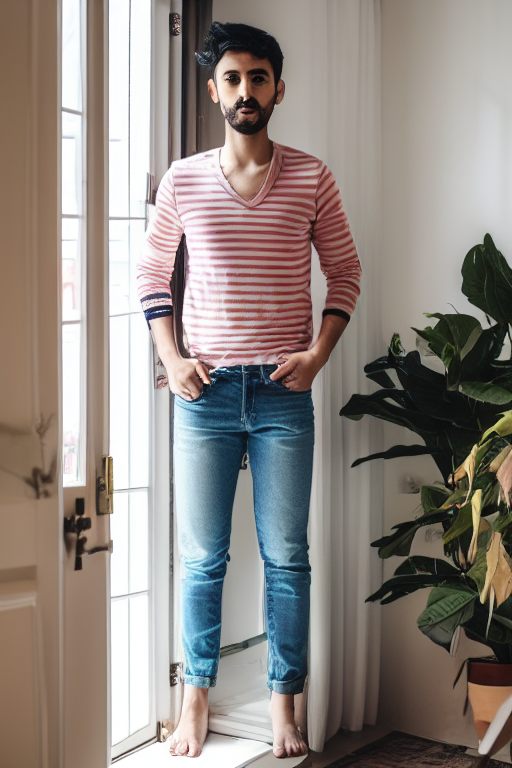

In [15]:
# seed 지정
generator = torch.manual_seed(45)

# prompts 정의
prompt = "A friend standing at home"
negative_prompt = "low-resolution, blurry, artifacts"

# 이미지 생성
openpose_image4 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # Higher steps for more detail
    guidance_scale=9.0,  # Controls adherence to prompt
    controlnet_conditioning_scale=1.2,  # Adjusts influence of OpenPose conditioning
    generator=generator,
    image=openpose_image
).images[0]

# 이미지 저장 및 출력
openpose_image4.save("/aiffel/aiffel/diffusers/openpose_image4.png")
openpose_image4.show()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('tcp'), Posix

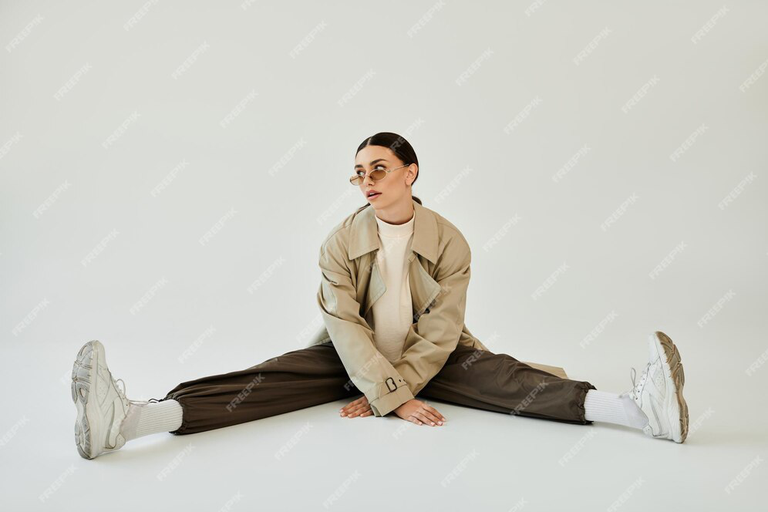

In [1]:
import torch
import gc
import cv2
from PIL import Image
import numpy as np
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

image_path = "/aiffel/aiffel/diffusers/pose_image.jpg" # 이미지 경로
openpose_image = Image.open(image_path).convert("RGB")  # RGB 변환

# 이미지 리사이징
def resize_image(image, new_width, new_height):
    return image.resize((new_width, new_height), Image.LANCZOS)

openpose_image = resize_image(openpose_image, 768, 512)

openpose_image

cuda


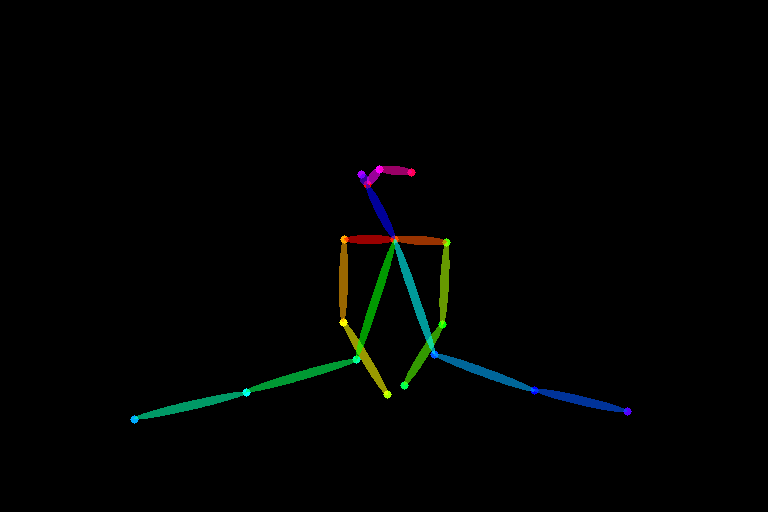

In [2]:
# OpenPoseDetector 모델 로드
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_result = openpose(openpose_image)

# 검출된 이미지 출력
openpose_result.show()

In [3]:
# ControlNet 모델 로드 (CPU 사용)
openpose_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", 
    low_cpu_mem_usage=True
)

# Stable Diffusion ControlNet Pipeline 로드 (CPU 모드)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=openpose_controlnet,
    low_cpu_mem_usage=True
)

# CPU에서 실행하도록 설정
openpose_pipe = openpose_pipe.to("cpu")

# 메모리 정리 (GPU 캐시 정리)
torch.cuda.empty_cache()
gc.collect()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


33

  0%|          | 0/30 [00:00<?, ?it/s]

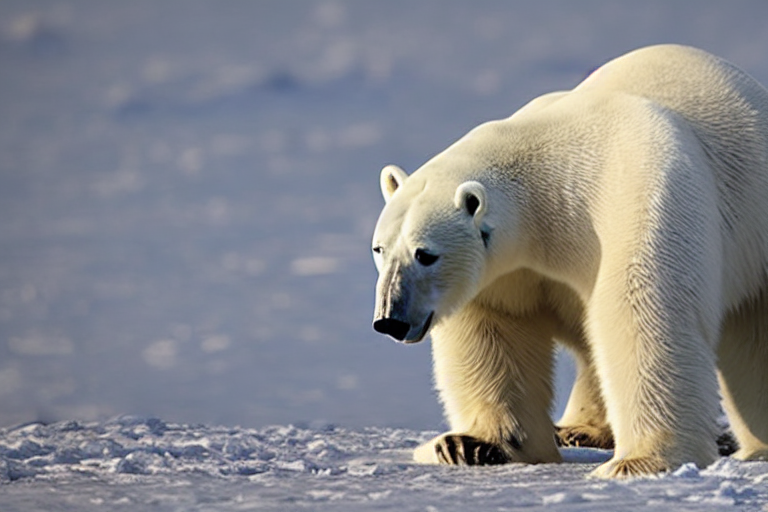

In [4]:
# seed 지정
generator = torch.manual_seed(46)

# prompts 정의
prompt = "polar bear"

# 이미지 생성
openpose_image5 = openpose_pipe(
    prompt=prompt,
    num_inference_steps=30,  # Higher steps for more detail
    guidance_scale=9.0,  # Controls adherence to prompt
    controlnet_conditioning_scale=1.2,  # Adjusts influence of OpenPose conditioning
    generator=generator,
    image=openpose_image
).images[0]

# 이미지 저장 및 출력
openpose_image5.save("/aiffel/aiffel/diffusers/openpose_image5.png")
openpose_image5.show()

In [7]:
# 메모리 삭제
torch.cuda.empty_cache()

## 윤곽선 검출 + 인체 자세 감지

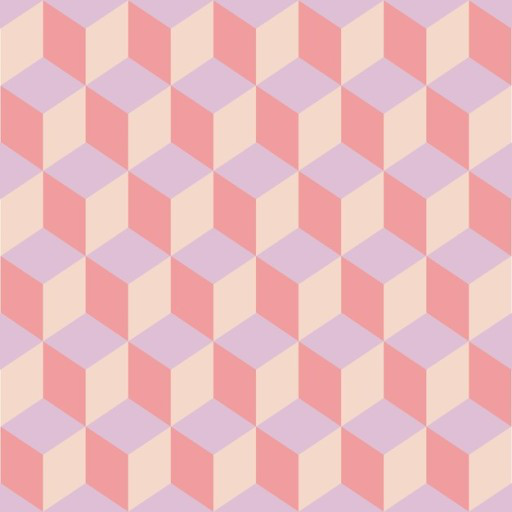

In [8]:
# Canny 알고리즘을 사용한 윤곽선 검출

from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
image_path = "/aiffel/aiffel/diffusers/background_image.jpg" # 이미지 경로
canny_image = Image.open(image_path)

canny_image

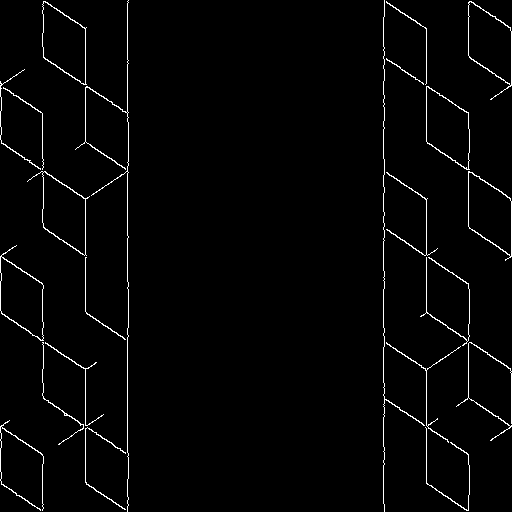

In [9]:
#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = np.expand_dims(canny_image, axis=2)
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

cuda


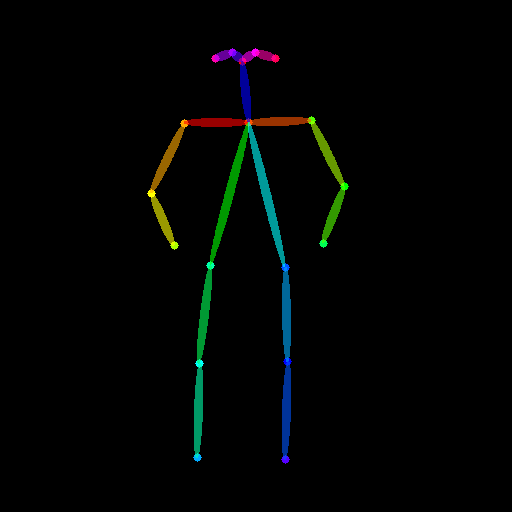

In [10]:
# Openpose를 사용한 인체 자세 검출

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

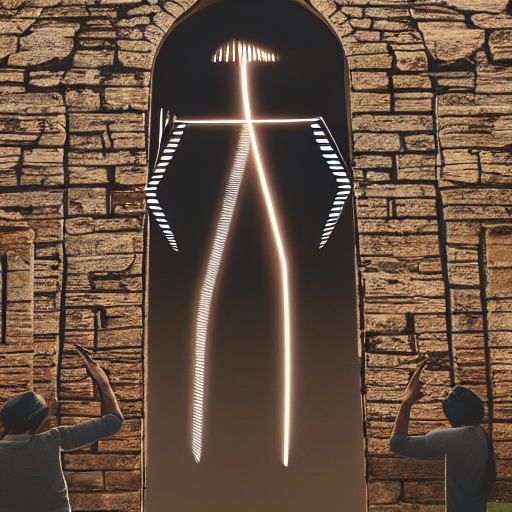

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "A friend standing at home"
negative_prompt = "blurry"

# seed를 지정합니다. 
generator = torch.manual_seed(25)

images = [openpose_image, canny_image]

# 이미지를 생성합니다.
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,
    guidance_scale=9.0,
    controlnet_conditioning_scale=[1.2, 1.0],  # 두 개의 ControlNet 스케일 지정
    generator=generator,
    image=[openpose_image, canny_image]
).images[0]

# 생성된 이미지를 저장합니다.
image.save("./multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image.show()

In [13]:
import os
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

# 모델 저장 경로 설정
model_base_dir = "/aiffel/aiffel/diffusers/model"
canny_dir = f"{model_base_dir}/controlnet_canny"
pose_dir = f"{model_base_dir}/controlnet_openpose"
sd_dir = f"{model_base_dir}/stable_diffusion"

# 폴더 생성 (이미 존재하면 무시)
os.makedirs(canny_dir, exist_ok=True)
os.makedirs(pose_dir, exist_ok=True)
os.makedirs(sd_dir, exist_ok=True)

# Canny Edge Detection ControlNet 저장
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_controlnet.save_pretrained(canny_dir)

# OpenPose ControlNet 저장
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_controlnet.save_pretrained(pose_dir)

# Stable Diffusion + ControlNet 모델 저장
sd_model = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=[canny_controlnet, openpose_controlnet],  # ✅ ControlNet 포함
    torch_dtype=torch.float16
)

sd_model.save_pretrained(sd_dir)

print("✅ 모든 모델이 '/aiffel/aiffel/diffusers/model' 폴더에 저장되었습니다!")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


✅ 모든 모델이 '/aiffel/aiffel/diffusers/model' 폴더에 저장되었습니다!


# 회고
- 프롬프트를 상세하게 작성할수록 오히려 의도했던 이미지에서 벗어나는 경우가 많았습니다.
- 이번 프로젝트에서는 하이퍼파라미터를 조정하면서 이미지가 어떻게 변형되는지 테스트하는 과정이 흥미로웠습니다.